# Actor-Critic

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gymnasium as gym

import matplotlib.pyplot as plt
from IPython import display

import tqdm

In [2]:
# 학습 파라미터
learning_rate = 0.0002
gamma         = 0.98
n_rollout     = 10  # 10번에 한번씩 학습

In [3]:
# Actor Network: 액션가치 네트워크
class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc_pi = nn.Linear(128, 2) # 정책 추론

    def forward(self, x): # 정책 추론 함수
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc_pi(x), dim=-1)
        return x

In [4]:
# Critic Network: 상태가치 네트워크
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc_v = nn.Linear(128, 1) # 가치 추론

    def forward(self, x): # 가치 추론 함수
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc_v(x)
        return x

In [5]:
def make_batch(buffer):
    s_lst, a_lst, r_lst, s_prime_lst, done_lst = [], [], [], [], []
    for transition in buffer:
        s, a, r, s_prime, done = transition
        s_lst.append(s)
        a_lst.append([a])
        r_lst.append([r/100.0])  # 보상을 편차를 작게 하면 학습이 잘 됨
        s_prime_lst.append(s_prime)
        done_mask = 0.0 if done else 1.0
        done_lst.append([done_mask])
    s_batch = torch.tensor(np.array(s_lst), dtype=torch.float)
    a_batch = torch.tensor(np.array(a_lst))
    r_batch = torch.tensor(np.array(r_lst), dtype=torch.float)
    s_prime_batch = torch.tensor(np.array(s_prime_lst), dtype=torch.float)
    done_batch = torch.tensor(np.array(done_lst), dtype=torch.float)

    return s_batch, a_batch, r_batch, s_prime_batch, done_batch

In [13]:
class ACAgent():
    def __init__(self):
        self.actor = Actor()  # Actor network
        self.critic = Critic()  # Critic network

    def prob_action(self, obs):
        return self.actor(obs)

    def update_ac(self, buffer, optim_pi, optim_v):
        s, a, r, s_prime, done = make_batch(buffer)

        target = r + gamma * self.critic(s_prime) * done
        delta = target - self.critic(s)
    
        pi = self.actor(s)
        pi_a = pi.gather(1, a.long())

        # 정책 네트워크 π: 가치 네트워크의 qϕ(s, a)를 이용해서 정책 개선
        loss_pi = -torch.log(pi_a) * delta.detach() # policy loss
        optim_pi.zero_grad()
        loss_pi.mean().backward()
        optim_pi.step()

        # 가치 네트워크 v: 정책 네트워크에 의해 결정된 s, R, s'을 이용해 가치 평가
        loss_v = F.mse_loss(self.critic(s), target.detach())  # value loss
        optim_v.zero_grad()
        loss_v.mean().backward()
        optim_v.step()

In [7]:
agent = ACAgent()

In [8]:
# optimizer
optim_pi = optim.Adam(agent.actor.parameters(), lr=learning_rate)
optim_v = optim.Adam(agent.critic.parameters(), lr=learning_rate)

In [9]:
score = 0.0
max_score = 0.0
history = []

env = gym.make("CartPole-v1", render_mode="rgb_array")

p_bar = tqdm.trange(2500)
for i in p_bar:
    s, _ = env.reset()

    done = False
    buffer = []
    while not done:
        for _ in range(n_rollout):
            prob = agent.prob_action(torch.from_numpy(s).float())  # 정책 추론
            a = Categorical(prob).sample().item()  # 확률 분포에 따른 액션 션택
            s_prime, r, done, oob, info = env.step(a)
            done = True if oob else done
            buffer.append((s, a, r, s_prime, done))
            s = s_prime
            
            score += r
            if done:
                break

        agent.update_ac(buffer, optim_pi, optim_v)

    if i % 10 == 9: # 10회 평균 저장
        p_bar.set_description(f'max: {max_score:.5f}, curr: {score:5f}')
        if score >= max_score: # 성능 개선이 있었으면
            torch.save(agent.actor.state_dict(), 'ac_actor.pth')
            torch.save(agent.critic.state_dict(), 'ac_critic.pth')
            max_score = score
        history.append(score) # learning history
        score = 0.0

p_bar.close()
env.close()


ax: 5000.00000, curr: 91.000000: 100%|████████████████████████████████████████████| 2500/2500 [09:54<00:00,  4.21it/s]

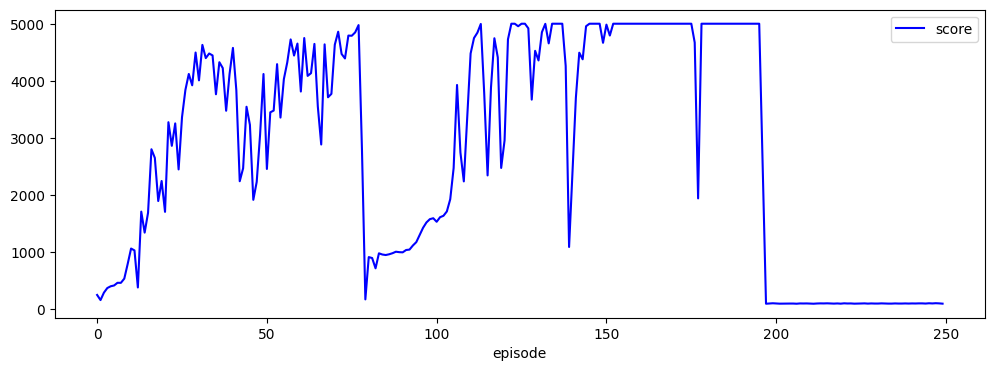

In [14]:
plt.figure(figsize=(12, 4))

plt.plot(history, 'b-', label='score')
plt.xlabel('episode')
plt.legend()
plt.show()

In [15]:
model = Actor()
model.load_state_dict(torch.load('ac_actor.pth'))

<All keys matched successfully>

500.0


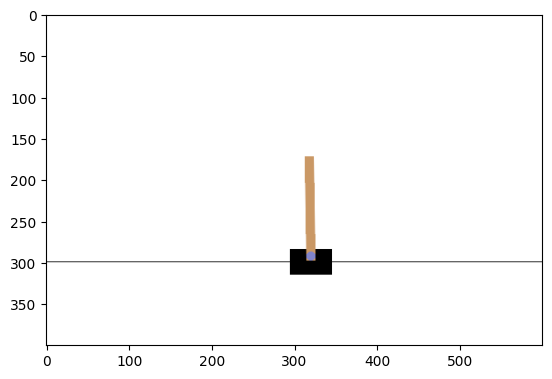

In [18]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
s, _ = env.reset()
img = plt.imshow(env.render())

score = 0.0
while True:
    # display
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    prob = model(torch.from_numpy(s).float())  # 정책 추론
    a = Categorical(prob).sample().item()  # 확률 분포에 따른 액션 션택
    s_prime, r, done, oob, info = env.step(a)
    s = s_prime
    
    score += r
    if done or oob:
        break

env.close()
print(score)